## **Competencia**

In [13]:
import os
import datetime
import urllib

import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest
from IPython.display import Image

In [14]:
def plot_coordinates(lat, long):
    #https://gis.stackexchange.com/questions/330798/how-to-put-a-google-map-image-or-any-other-map-layers-under-my-utm-cordinates
    center_lat = lat.mean()
    center_long = long.mean()
    token = "pk.eyJ1Ijoia2FwYXN0b3IiLCJhIjoiY2p3eTg3eWJoMG1jZjQ4bzZmcGg5c3F3cSJ9.vhyCyD9xDDGP9EQnhB9xtA"
    tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
    my_map = folium.Map(location=[center_lat, center_long], tiles=tileurl, attr='Mapbox', max_zoom=30, zoom_start=18)
    for i in range(len(lat)):
        location = (lat[i], long[i])
        folium.CircleMarker(location=[lat[i], long[i]], radius=2).add_to(my_map)
    return my_map

In [15]:
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [2]:
path = "/home/augusto/Github/DesafioAgTech2020/"

train = pd.read_csv(path + "dataset/data_train.csv")
test = pd.read_csv(path + "dataset/data_test.csv")

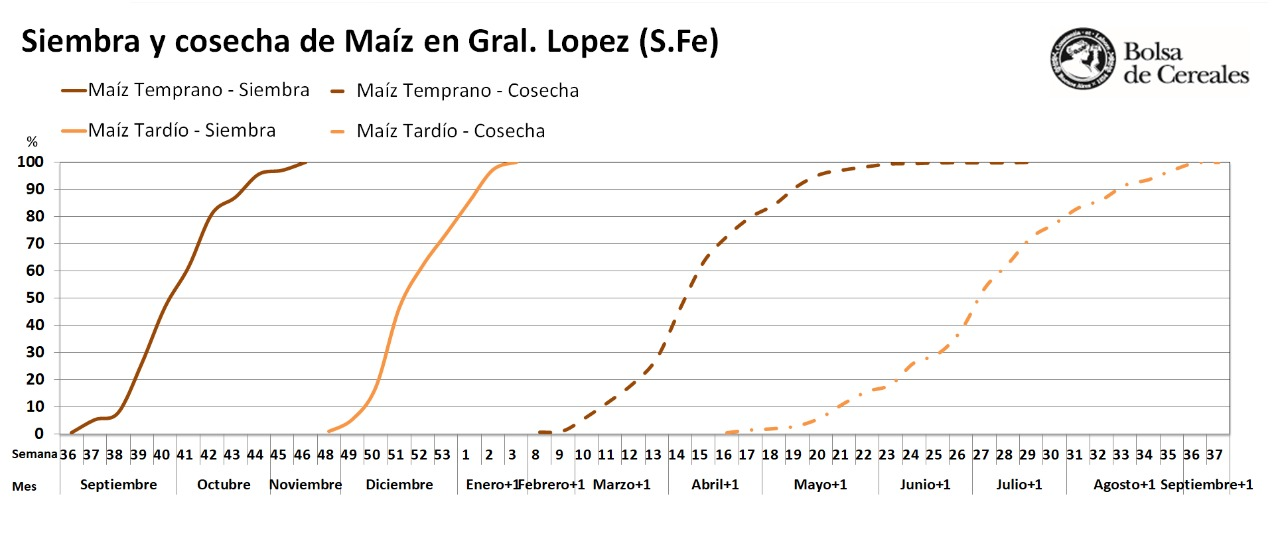

In [3]:
Image(path + "www/bc_maiz.jpeg")

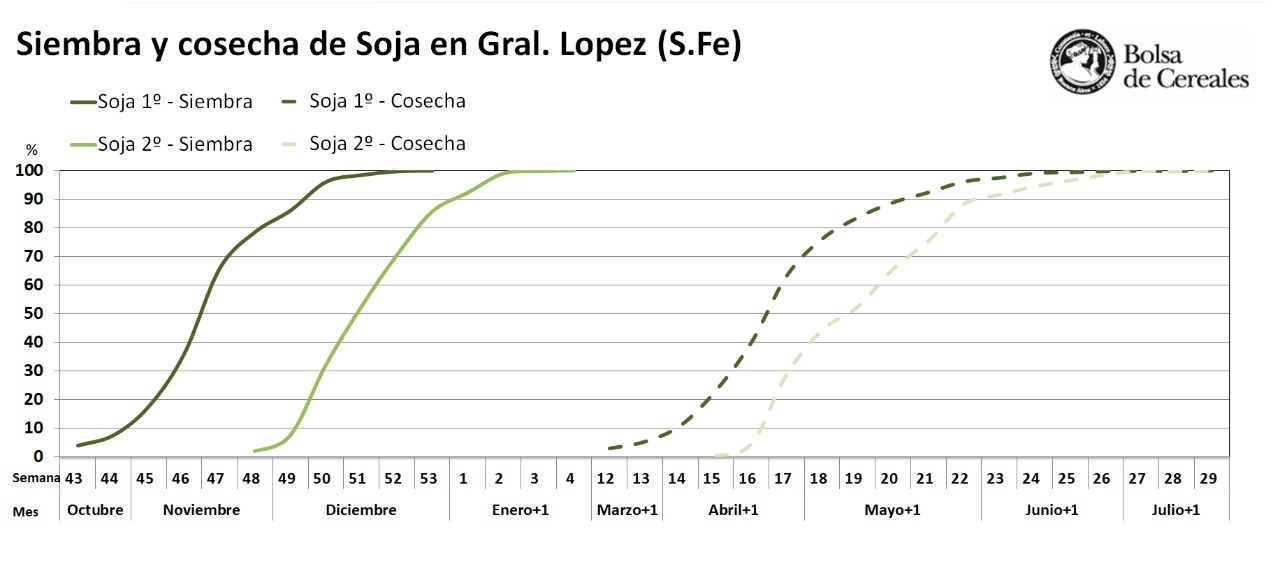

In [4]:
Image(path + "www/bc_soja.jpeg")

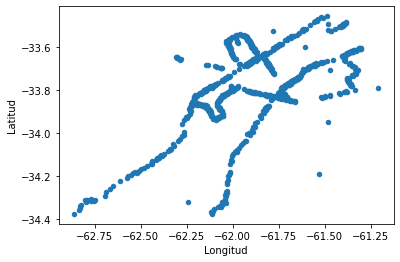

In [5]:
train.plot.scatter(x="Longitud", y="Latitud")

In [9]:
train_map = plot_coordinates(train["Latitud"], train["Longitud"])

In [175]:
train_map

**SENTINELHUB**

In [21]:
CLIENT_ID = '81bf3f52-6953-414b-a539-358a3fed12d8'
CLIENT_SECRET = 'a})ewR[qL#ZTzB(nW?ui3;m18M{7v!eP:GN6axyy'

In [22]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

In [16]:
test = [-62.144163, -33.800002, -62.154163, -33.810202]

In [332]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]

In [18]:
resolution = 10
betsiboka_bbox = BBox(bbox=test, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 10 m resolution: (93, 112) pixels


In [191]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", "B08", "B11", "B12"],
            }],
            output: {
                bands: 6
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02, sample.B08, sample.B11, sample.B12];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2020-02-01', '2020-03-01'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [192]:
true_color_imgs = request_true_color.get_data()

In [ ]:
ndvi = np.stack((true_color_imgs[0][:, :, 3] - true_color_imgs[0][:, :, 0]) / (true_color_imgs[0][:, :, 3] + true_color_imgs[0][:, :, 0]))

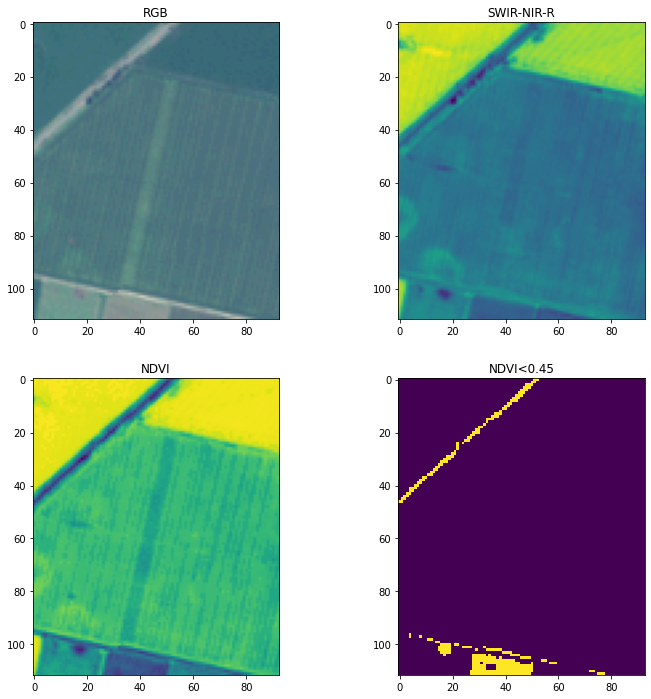

In [193]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1) , plt.imshow(true_color_imgs[0][:, :, :3]*6.3/255), plt.title("RGB")
plt.subplot(2,2,2) , plt.imshow(true_color_imgs[0][:, :, 3]*6.3/255) ,plt.title("SWIR-NIR-R")
plt.subplot(2,2,3) , plt.imshow(ndvi), plt.title("NDVI")
plt.subplot(2,2,4) , plt.imshow(ndvi < 0.5, interpolation='nearest') ,plt.title("NDVI<0.45");

In [195]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (112, 93, 4)
